<a href="https://colab.research.google.com/github/hursoo/big_k-modern_1/blob/main/gb_051_dmr_%EC%8B%9C%EA%B8%B0%EA%B5%AC%EB%B6%84_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.개요
- 생성한 dmr 모델 불러와서 시기구분
- dtm: doc는 여기서는 구간(grid). term은 여기서는 토픽. 값은 구간별 토픽 분포 -> 그래프로 시각화
- 시기구분 판단은 계층적 클러스터링 사용

In [ ]:
# 구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 경로 지정

file_path = '/content/drive/MyDrive/_big1_25-1_code/'

In [ ]:
## 런타임 다시 시작 후엔 이 셀 건너뛸 것 !

# =================================================================
# 1단계: 나눔 폰트 설치 (이 셀을 실행한 후, 런타임을 다시 시작해야 합니다)
# =================================================================
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
!pip install tomotopy

In [ ]:
import sys
import os, re
import pandas as pd
import numpy as np
import random
import warnings

from tomotopy import DMRModel
from tomotopy import TermWeight
from tomotopy import utils
import tomotopy as tp

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕으로 설정 (Colab 기본 포함) ###
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 정상 표시되도록 설정

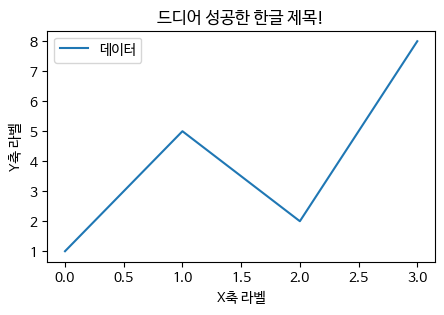

In [ ]:
# --- 이제 그래프를 그려도 경고가 뜨지 않습니다. ---

# 예시 그래프
# (여기에 원래 그리려던 그래프 코드를 넣으시면 됩니다)
plt.figure(figsize=(5, 3))
plt.title('드디어 성공한 한글 제목!')
plt.xlabel('X축 라벨')
plt.ylabel('Y축 라벨')
plt.plot([1, 5, 2, 8], label='데이터')
plt.legend()
plt.show()

# 2.모델 불러오기

In [ ]:
#모델 불러오기 + 메타데이터 출력
model = DMRModel.load(file_path + 'result/gb_n_dmr_model(k=4,seed=100,0.05,0.1).bin')
model.metadata_dict

['01q', '02q', '03q', '04q', '05q', '06q', '07q', '08q', '09q', '10q', '11q', '12q', '13q', '14q', '15q', '16q', '17q', '18q', '19q', '20q', '21q', '22q', '23q', '24q']

In [ ]:
# 모델 요약 출력
model.summary(topic_word_top_n=20)

<Basic Info>
| DMRModel (current version: 0.13.0)
| 6802 docs, 257159 words
| Total Vocabs: 5828, Used Vocabs: 5828
| Entropy of words: 7.43552
| Entropy of term-weighted words: 7.43552
| Removed Vocabs: <NA>
| Metadata of docs and its distribution
|  01q: 193
|  02q: 223
|  03q: 296
|  04q: 292
|  05q: 435
|  06q: 333
|  07q: 410
|  08q: 413
|  09q: 152
|  10q: 298
|  11q: 315
|  12q: 261
|  13q: 198
|  14q: 393
|  15q: 456
|  16q: 254
|  17q: 154
|  18q: 201
|  19q: 223
|  20q: 224
|  21q: 226
|  22q: 248
|  23q: 324
|  24q: 280
|
<Training Info>
| Iterations: 1000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.58973
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 4 (the number of topics between 1 ~ 32767)
| alpha: [0.05] (an initial value of exponential of mean of normal distribution for `lambdas`, giv

# 3.구간별 토픽 분포

## 3.1.분포 산출

In [ ]:
# 구간별 topic 배분 산출

k = 4  ###

# 다음 파일명으로 해당 디렉토리에 저장
# save alpha (Dirichlet prior on the per-document topic distributions for each metadata)
out = open(file_path + "result/grid-distrib.txt", 'w', encoding='utf-8')  ###

# calculate topic distribution for each metadata using softmax
probs = np.exp(model.lambdas - model.lambdas.max(axis=0))
probs /= probs.sum(axis=0)

print('Topic distributions for each metadata')
out.write('Topic distributions for each metadata\n\n')

for f, metadata_name in enumerate(model.metadata_dict):
    out.write('\t{}'.format(metadata_name))
out.write('\n')

for i in range(0,k):
    out.write('Topic #{}'.format(i))
    #print(i, probs[i])
    for j in range(len(model.metadata_dict)):
        out.write('\t{:.8f}'.format(probs[i][j]))
    out.write('\n')

out.close()

Topic distributions for each metadata


## 3.2.시각화

In [ ]:
# 텍스트 파일을 DataFrame으로 로드
def load_topic_distribution(file_path):
    """
    텍스트 파일에서 구간별 토픽 분포 데이터를 로드.
    Parameters:
        file_path (str): 텍스트 파일 경로.
    Returns:
        pd.DataFrame: 구간별 토픽 분포 데이터프레임 (행: 토픽, 열: 구간).
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # 데이터 파싱
    topic_names = []
    data = []
    for line in lines:
        if line.startswith("Topic #"):
            parts = line.split("\t")
            topic_name = parts[0].strip()
            topic_values = [float(x) for x in parts[1:] if x.strip()]
            topic_names.append(topic_name)
            data.append(topic_values)

    # 구간 라벨 생성
    num_intervals = len(data[0])  # 각 토픽의 구간 수
    intervals = [f"{i+1:02}q" for i in range(num_intervals)]

    # DataFrame 생성
    df = pd.DataFrame(data, index=topic_names, columns=intervals)
    return df


# 데이터 시각화 (토픽 #2만 굵은 실선으로 표시)
def plot_topic_distribution_custom(df):
    """
    구간별 토픽 분포를 시각화 (토픽 #1만 굵은 실선, 나머지는 점선으로 표시).

    Parameters:
        df (pd.DataFrame): 구간별 토픽 분포 데이터프레임 (행: 토픽, 열: 구간).
    """
    plt.figure(figsize=(10, 6))
    for topic in df.index:
        if topic == "Topic #2":
            plt.plot(df.columns, df.loc[topic], label=topic, marker='o', linestyle='-', linewidth=2.5)
        else:
            plt.plot(df.columns, df.loc[topic], label=topic, marker='o', linestyle='--', linewidth=1.5)

    plt.title("Topic Distributions Across Grids", fontsize=16)
    plt.xlabel("Grids", fontsize=14)
    plt.ylabel("Topic Proportion", fontsize=14)
    plt.legend(title="Topics", fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

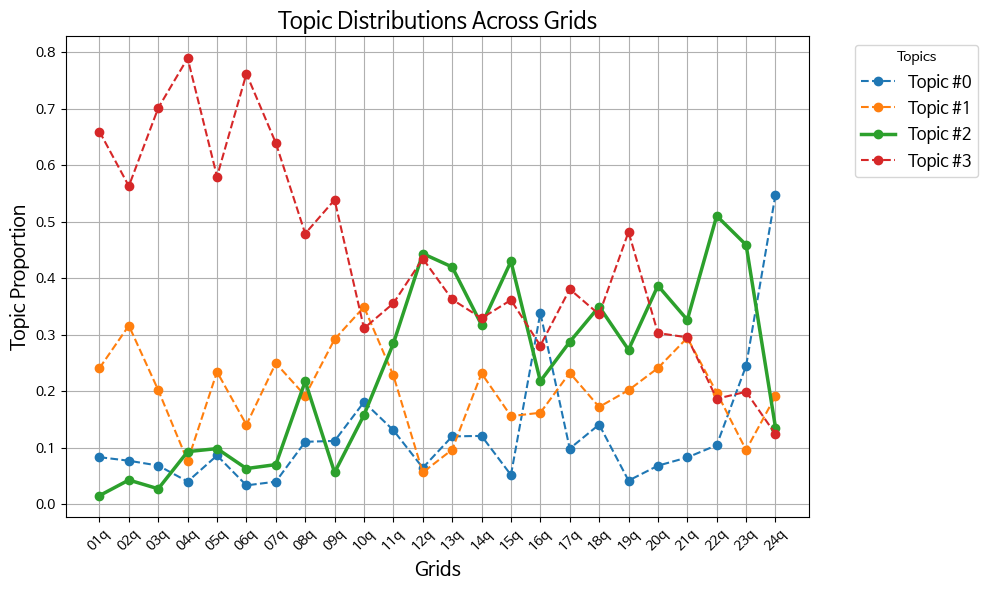

In [ ]:
# 파일 경로
file_name = "result/grid-distrib.txt"  # 텍스트 파일 경로를 설정하세요.

# 데이터 로드 및 시각화
df = load_topic_distribution(file_path + file_name)
plot_topic_distribution_custom(df)

# 4.시기구분
- 계층적 클러스터링 사용

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# 계층적 클러스터링 수행 및 시각화
def perform_hierarchical_clustering(data, method="ward", metric="euclidean", max_clusters=5):
    """
    구간별 토픽 분포 데이터를 기반으로 계층적 클러스터링을 수행.

    Parameters:
        data (pd.DataFrame): 구간별 토픽 분포 데이터 (행: 구간, 열: 토픽).
        method (str): 계층적 클러스터링 방법 ('ward', 'single', 'complete', 'average' 등).
        metric (str): 거리 측정 방법 ('euclidean', 'cosine' 등).
        max_clusters (int): 클러스터 개수를 결정할 최대값.

    Returns:
        clusters (list): 각 구간이 속한 클러스터 번호 리스트.
    """
    # 데이터 유사도 계산 및 계층적 클러스터링 수행
    linkage_matrix = linkage(data, method=method, metric=metric)

    # 덴드로그램 시각화
    plt.figure(figsize=(6, 4))
    dendrogram(linkage_matrix, labels=data.index, leaf_rotation=90, leaf_font_size=10)
    plt.title("Hierarchical Clustering Dendrogram", fontsize=16)
    plt.xlabel("Grids", fontsize=14)
    plt.ylabel("Distance", fontsize=14)
    plt.tight_layout()
    plt.show()

    # 클러스터링 결과 생성
    cluster_labels = fcluster(linkage_matrix, max_clusters, criterion='maxclust')

    # 클러스터 결과 출력
    print("Cluster Labels:")
    for interval, cluster in zip(data.index, cluster_labels):
        print(f"{interval}: Cluster {cluster}")

    return cluster_labels

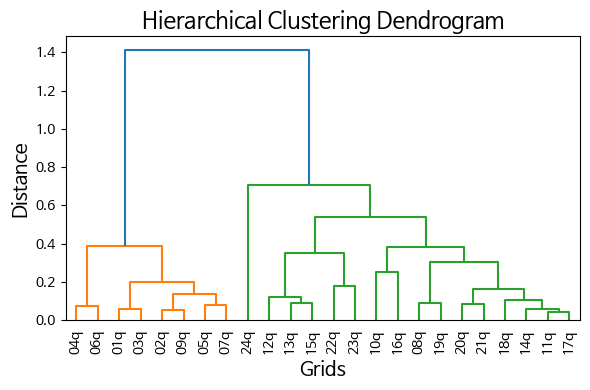

Cluster Labels:
01q: Cluster 1
02q: Cluster 1
03q: Cluster 1
04q: Cluster 1
05q: Cluster 1
06q: Cluster 1
07q: Cluster 1
08q: Cluster 2
09q: Cluster 1
10q: Cluster 2
11q: Cluster 2
12q: Cluster 2
13q: Cluster 2
14q: Cluster 2
15q: Cluster 2
16q: Cluster 2
17q: Cluster 2
18q: Cluster 2
19q: Cluster 2
20q: Cluster 2
21q: Cluster 2
22q: Cluster 2
23q: Cluster 2
24q: Cluster 2

Clustered DataFrame:
     Topic #0  Topic #1  Topic #2  Topic #3  Cluster
01q  0.083575  0.241131  0.015519  0.659775        1
02q  0.077257  0.316378  0.043139  0.563226        1
03q  0.068731  0.202230  0.027609  0.701431        1
04q  0.040404  0.076684  0.093377  0.789535        1
05q  0.086538  0.234583  0.098769  0.580110        1
06q  0.033675  0.140867  0.063431  0.762026        1
07q  0.040219  0.249839  0.070415  0.639527        1
08q  0.110781  0.192265  0.217794  0.479160        2
09q  0.112338  0.292297  0.056466  0.538899        1
10q  0.181041  0.349288  0.158134  0.311537        2
11q  0.131241  0.22

In [ ]:
# 데이터 로드
file_name = "result/grid-distrib.txt"  # 구간별 토픽 분포 텍스트 파일
df = load_topic_distribution(file_path + file_name)  # 앞서 작성한 함수 사용

# 계층적 클러스터링 수행
df_transposed = df.T  # 구간을 행으로, 토픽을 열로 변환
clusters = perform_hierarchical_clustering(df_transposed, method="ward", metric="euclidean", max_clusters=2) ###
"""
- 구간별 토픽의 절대적 크기 차이를 중시한다면 → 유클리디언 거리.
- cf) 패턴이 중요한 경우: 구간별 토픽 분포의 상대적 패턴(예: 증가/감소의 방향)만을 비교하고 싶을 때.
      예: 구간별로 유사한 변화 추이를 가진 데이터를 같은 클러스터로 묶고 싶을 때.
"""
# 클러스터 결과를 데이터프레임에 추가
df_transposed["Cluster"] = clusters
print("\nClustered DataFrame:")
print(df_transposed)

시기 구분 경계선 제안 (사회주의 토픽 중심)
- 가장 설득력 있는 경계선: 09q ↔ 10q 사이
- 이유:
    - 08q는 급등이 시작된 기점이지만, 09q에서 다시 하락 → 일시적 요동 가능성
    - 10q부터는 Topic #1이 지속적으로 높게 유지되며, 사회주의 담론이 본격화됨
    - 이후 구간은 Cluster 2로 안정되며, Topic #1이 분석 주제의 중심으로 자리잡음
- 전기: 01q ~ 09q (9)
- 후기: 10q ~ 24q (15)

# The End of Note